In [1]:
# ! pip install -e 'git://github.com/nandanrao/embed-software.git#egg=embed_software'

In [2]:
# ! pip install --quiet fuzzywuzzy gcsfs

In [3]:
import time
import sys
import logging
import math
import random
import json
import pickle
from collections import Counter

import numpy as np
import pandas as pd

from gcsfs import GCSFileSystem

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
#import torchtext

from validation.data import *

/opt/conda/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
# from src.model import StarSpace

In [5]:
# torch.autograd.set_detect_anomaly(True)

In [6]:
from src.adv_model import *

In [7]:
def nan_test(l_batch, r_batch, neg_batch):
    global nan_break
    
    l_test = np.isnan(np.mean(l_batch.detach().cpu().numpy()))
    r_test = np.isnan(np.mean(r_batch.detach().cpu().numpy()))
    neg_test = np.isnan(np.mean(neg_batch.detach().cpu().numpy()))
    if l_test or r_test or neg_test:
        nan_break = True
        return True

In [8]:
SAMPLE_SIZE = 10000
SOC_LEVEL = 3
OUTPUT_WEIGHTS = 'data/adversarial/'

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("Using device", device)

Using device cuda


In [10]:
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)
formatter = logging.Formatter(fmt="%(asctime)s %(levelname)s: %(message)s", 
                          datefmt="%Y-%m-%d - %H:%M:%S")
fh = logging.FileHandler("adversarial_model.log", "w")
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

In [11]:
log.info('Pulling Indeed data for sample size %s' % SAMPLE_SIZE)

In [12]:
# Get job ads data
indeed = get_indeed_texts('../data/us/everything.csv',use_gcs=True,nrows=SAMPLE_SIZE)
indeed = indeed['content']

In [13]:
train = indeed.copy()
del indeed

In [14]:
# Get DOT classifications data
dot, dot_labs = dot_train_data(SOC_LEVEL)

dot = dot.reset_index(drop=True)
dot_labs = dot_labs.reset_index(drop=True)

In [15]:
log.info('About to train vocab')

In [16]:
embedder = Embedder(d_embed=100)
embedder.train_vocab(train)

print(len(embedder.vocab))
log.info('Trained Vocab of size %s' % str(len(embedder.vocab)))

12431


In [17]:
# #Save the file
with open(OUTPUT_WEIGHTS + 'train_vocab_%s' % SAMPLE_SIZE, 'wb') as f:
    pickle.dump(embedder.vocab, f)

In [18]:
train_pos = embedder.get_positions(train)
dot_positions = embedder.get_positions(dot)

for i in range(len(train_pos)):
    for j in range(len(train_pos[i])):
        train_pos[i][j] = train_pos[i][j].to(device)

for i in range(len(dot_positions)):
    for j in range(len(dot_positions[i])):
        dot_positions[i][j] = dot_positions[i][j].to(device)

In [19]:
starspace = StarSpaceAdv(
    input_embedder = embedder,
    k_neg = 10,
    lr = .01)

starspace.to(device)

StarSpaceAdv()

In [20]:
discriminator = Discriminator(
    classifier = LogisticRegression(100,2),
    embedder = embedder,
    lr = .001)

criterion = nn.CrossEntropyLoss()

In [21]:
#Run parameters
epochs = 3
print_every = 100
log_every = 10
batch_size = 100

#Losses
lambdas = dict([['starspace',.02],
                ['adv',.98]])
star_losses = []
disc_losses1 = []
disc_losses2 = []
acc_losses = []

epoch_losses = [1e12]
disc_epoch_losses1 = [1e12]
disc_epoch_losses2 = [1e12]

log.info('Beginning run')

In [22]:
#Real loop
for epoch in range(epochs):
    permutation = torch.randperm(len(train_pos)).numpy()
    nan_break = False
    
    for i in range(0,len(train), batch_size):
        indices = permutation[i:i+batch_size]
        batch = train_pos[indices]

        ###### Forward Pass- StarSpace #############################################################
        starspace.train(); starspace.opt.zero_grad()
        
        l_batch, r_batch, neg_batch = starspace(batch)
        
        #Test for nans
        if nan_test(l_batch, r_batch, neg_batch):
            break
        
        positive_similarity = torch.bmm(l_batch,r_batch.transpose(2,1))
        negative_similarity = torch.mean(torch.bmm(l_batch, neg_batch.transpose(2,1)).squeeze(1),1)

        star_loss = torch.sum(torch.clamp(.1 - positive_similarity + \
                                          negative_similarity, min=0)) * lambdas['starspace']
        
        ###### Forward Pass- Discriminator ############################################################
        outputs, disc_y = discriminator(batch, dot_positions)
        disc_loss1 = criterion(outputs,disc_y) * lambdas['adv']
        
        ###### Backward Pass- Embeddings ##############################################################
        emb_loss = star_loss + disc_loss1
        emb_loss.backward(); starspace.opt.step()
        
        ###### Forward Pass 2- Discriminator ###########################################################
        discriminator.train(); discriminator.opt.zero_grad()
        
        outputs, disc_y = discriminator(batch, dot_positions)
        #ridge = .1 * torch.norm(torch.cat([x.view(-1) for x in discriminator.parameters()]), 2)
        disc_loss2 = criterion(outputs,disc_y) * lambdas['adv'] * -1
        
        ###### Backward Pass 2- Discriminator ############################################################
        disc_loss2.backward(); discriminator.opt.step()
        
        acc = 100 * (outputs.max(1).indices == disc_y).sum().item() / 200
        
        discriminator.opt.zero_grad()
        
        ###### Batch Print/Log #########################################################################
        star_losses.append(star_loss.detach().cpu().numpy())
        disc_losses1.append(disc_loss1.detach().cpu().numpy())
        disc_losses2.append(disc_loss2.detach().cpu().numpy())
        acc_losses.append(acc)
        
        if (i % (print_every*batch_size) == 0) & (i > 0):
            print('star avg loss: %s' % str(np.mean(star_losses[-10:])))
            print('discriminator CEL: %s' % str(np.mean(disc_losses1[-10:])))
            print('discriminator accuracy: %s' % str(np.mean(acc_losses[-10:])))
        if (i % (log_every*batch_size) == 0) & (i > 0):
            log.info('star avg loss: %s' % str(np.mean(star_losses[-10:])))
            log.info('discriminator CEL: %s' % str(np.mean(disc_losses1[-10:])))
            log.info('discriminator accuracy: %s' % str(np.mean(acc_losses[-10:])))
    
    # End of inner loop
    if nan_break:
        print("you've got nans")
        log.warning("you've got nans")
        break
    
    ###### Epoch Print/Log #############################################################################
    print('Finished epoch %s at %s.' % (epoch,time.ctime()))
    log.info("Finished epoch %s" % str(epoch))
    
    epoch_loss = np.mean(star_losses[-int(SAMPLE_SIZE/batch_size):])
    disc_epoch_loss1 = np.mean(disc_losses1[-int(SAMPLE_SIZE/batch_size):])
    disc_epoch_loss2 = np.mean(disc_losses2[-int(SAMPLE_SIZE/batch_size):])

    if (epoch_loss < min(epoch_losses)) | (len(epoch_losses) == 0):
        print('best epoch so far!')
        log.info('best epoch so far!')
        
        weights = embedder.weights.weight
        with open(OUTPUT_WEIGHTS + 'weights_best_epoch', 'wb') as f:
            pickle.dump(weights.data.detach().cpu().numpy(), f)
    
    epoch_losses.append(epoch_loss)
    disc_epoch_losses1.append(disc_epoch_loss1)
    disc_epoch_losses2.append(disc_epoch_loss2)
    print(epoch_losses)

Finished epoch 0 at Thu Jun 25 21:14:22 2020.
best epoch so far!
[1000000000000.0, 16.795113]
Finished epoch 1 at Thu Jun 25 21:15:33 2020.
best epoch so far!
[1000000000000.0, 16.795113, 12.976633]
Finished epoch 2 at Thu Jun 25 21:16:45 2020.
best epoch so far!
[1000000000000.0, 16.795113, 12.976633, 10.730926]


In [23]:
weights = embedder.weights.weight
with open(OUTPUT_WEIGHTS + 'weights_%s' % SAMPLE_SIZE, 'wb') as f:
    pickle.dump(weights.data.detach().cpu().numpy(), f)

In [24]:
print('You made it!')
log.info('You made it!')

You made it!


In [25]:
# #Save the weights to CSV
# weights = model.input_embedding.weight
# weights = weights.data.detach().numpy()
# np.savetxt("weights_%s.csv" % SAMPLE_SIZE, weights, delimiter=",")

In [26]:
epoch_losses

[1000000000000.0, 16.795113, 12.976633, 10.730926]

In [27]:
disc_epoch_losses1

[1000000000000.0, 0.7241344, 0.8767273, 1.0471184]

In [28]:
disc_epoch_losses2

[1000000000000.0, -0.7228906, -0.8757297, -1.0505126]

### Some graphing?

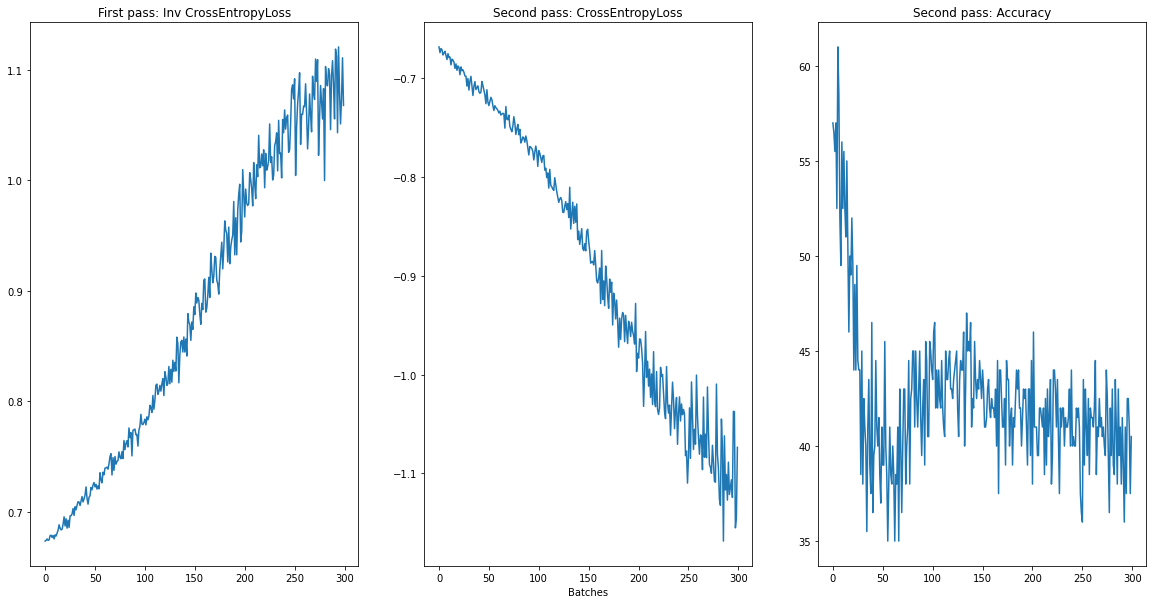

In [29]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

fig, axes = plt.subplots(1, 3)
axes[0].plot(range(len(disc_losses1)),disc_losses1)
axes[0].set_title('First pass: Inv CrossEntropyLoss')
axes[1].plot(range(len(disc_losses1)),disc_losses2)
axes[1].set_title('Second pass: CrossEntropyLoss')
axes[1].set_xlabel('Batches')
axes[2].plot(range(len(disc_losses1)),acc_losses)
axes[2].set_title('Second pass: Accuracy')
plt.show()


### the CrossEntropyLoss bit

In [30]:
# crit = nn.CrossEntropyLoss()

# t1_X = torch.stack([torch.tensor([1.,0.]) for _ in range(10)] + [torch.tensor([0.,1.]) for _ in range(10)])

# y0 = torch.tensor([1]*10 + [0] * 10)
# y1 = torch.tensor([0]*10 + [1] * 10)
# y2 = torch.tensor([1]*20)

# crit(t1_X,y0) #all wrong

# crit(t1_X,y1) #all right

# crit(t1_X,y2) #half right

# t2_X = torch.stack([torch.tensor([.5,.5]) for _ in range(20)])

# crit(t2_X,y0)

# crit(t2_X,y1)

# crit(t2_X,y2)

### Testing the weights changing

In [31]:
# epoch = 0
# permutation = torch.randperm(len(train_pos)).numpy()
# nan_break = False
# i = 0

# indices = permutation[i:i+batch_size]
# batch = train_pos[indices]

# def flatten_params(params):
#     disc_p = []
#     for p in params:
#         disc_p.append(p.clone().detach().cpu().numpy())

#     return np.array([item for sublist in disc_p for item in sublist.flatten()])

# ew_1 = embedder.weights.weight.clone().detach().cpu().numpy().flatten()
# disc_1 = flatten_params(discriminator.classifier.parameters())

# ###### Forward Pass- StarSpace #############################################################
# starspace.train(); starspace.opt.zero_grad()

# l_batch, r_batch, neg_batch = starspace(batch)

#Test for nans
# if nan_test(l_batch, r_batch, neg_batch):
#     break

# positive_similarity = torch.bmm(l_batch,r_batch.transpose(2,1))
# negative_similarity = torch.bmm(l_batch, neg_batch.transpose(2,1)).squeeze(1)

# star_loss = torch.sum(torch.clamp(.1 - positive_similarity + negative_similarity, min=0))

# star_loss.backward(); starspace.opt.step()

# ew_2 = embedder.weights.weight.clone().detach().cpu().numpy().flatten()
# disc_2 = flatten_params(discriminator.classifier.parameters())

# print('Embeddings changed: %s' % any(ew_1 != ew_2))
# print('Discriminator params updated: %s' % any(disc_1 != disc_2))

# ###### Forward Pass- Discriminator ###########################################################
# discriminator.train(); discriminator.opt.zero_grad()
# disc_loss, outputs, disc_y = discriminator(batch, dot_positions)

# acc = 100 * (outputs.max(1).indices == disc_y).sum().item() / 200

# disc_loss.backward(); discriminator.opt.step()

# ew_3 = embedder.weights.weight.clone().detach().cpu().numpy().flatten()
# disc_3 = flatten_params(discriminator.classifier.parameters())

# print('Embeddings changed: %s' % any(ew_2 != ew_3))
# print('Discriminator params updated: %s' % any(disc_2 != disc_3))